## Сегментация опухолей мозга с помощью UNet (Краснов А)

<img src="https://i.imgur.com/Q8oI4M6.png" 
     align="right" 
     width="300"
     style="padding: 20px;" />

Цель домашней работы - обучить [UNet](https://arxiv.org/abs/1505.04597) для сегментации опухолей головного мозга



### Загрузка данных
Данные представлены в виде питоновского словаря, где пары изображение-маска сохранены как .h5 файл, с ключами `image` и `mask`.

Датасет доступен по [ссылке](https://disk.yandex.ru/d/D_x_9woD55P8_g)

In [1]:
class SimpleLogger:
  level = 0

  def debug(self, *params):
    if self.level == 0:
      print('\033[1m[DEBUG]\033[0m:', *params)

  def info(self, *params):
    if self.level <= 1:
      print('\033[96m\033[1m[INFO]\033[0m:', *params)

  def warning(self, *params):
    if self.level <= 2:
      print('\033[93m\033[1m[WARNING]\033[0m:', *params)

  def error(self, *params):
    if self.level <= 3:
      print('\033[31m\033[1m[ERROR]\033[0m:', *params)

  def set_level(self, level=0):
    self.level = level


log = SimpleLogger()
log.set_level(0)

In [2]:
# Yandex Datashphere allowed path
HOME_DIR = '/home/jupyter/work/resources/'

In [3]:
import requests
from urllib.parse import urlencode
from urllib.request import urlretrieve
import os
from tqdm import tqdm


class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        log.info('Filepath already exists. Skipping download.')
        return

    with TqdmUpTo(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def yandex_disk_to_direct_link(ya_disk_link):
  base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
  final_url = base_url + urlencode(dict(public_key=ya_disk_link))
  link = requests.get(final_url).json()['href']
  return link

In [4]:
import shutil
# Download dataset
if not os.path.exists(HOME_DIR+'/dataset'):
  YA_DISK_DATASET_LINK = 'https://disk.yandex.ru/d/D_x_9woD55P8_g'
  download_url(yandex_disk_to_direct_link(YA_DISK_DATASET_LINK), HOME_DIR+'/dataset.zip')
  %time shutil.unpack_archive(HOME_DIR+'/dataset.zip', HOME_DIR+'/dataset')
else:
  log.info('Dataset already exists')


[INFO]: Dataset already exists


In [5]:
import numpy as np
import os
import h5py

def deisplay_info(idx=25070):
    file_path = os.path.join(DATA_DIR, H5_FILES[idx])
    with h5py.File(file_path, 'r') as file:
        print('\nKeys for each file:', list(file.keys()))
        for key in file.keys():
            print(f'\nData type of {key}: {type(file[key][()])}\n'
                  f'Shape of {key}: {file[key].shape}\n'
                  f'Array dtype: {file[key].dtype}\n'
                  f'Array max val: {np.max(file[key])}\n'
                  f'Array min val: {np.min(file[key])}')
    

# Directory containing .h5 files
DATA_DIR = HOME_DIR + '/dataset/BraTS2020_training_data/content/data'

# Create a list of all .h5 files in the directory
H5_FILES = [f for f in os.listdir(DATA_DIR) if f.endswith('.h5')]
log.info(f'Found {len(H5_FILES)} .h5 files:\n'
      f'Example file names: {H5_FILES[:3]}')

# Open the first .h5 file in the list to inspect its contents
if H5_FILES:
    deisplay_info()
else:
    log.error('No .h5 files found in the directory.')

[INFO]: Found 57195 .h5 files:
Example file names: ['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


## О данных
В нашема датасете снимки МРТ головного мозга вместе с маской, показывающий на абнормальные участки тканей головного мозга. У каждого изображения 4 канала

#### Каналы:
1) **T1-weighted (T1)**: Канал, хранящий в себе изображение структуры тканей головного мозга в высоком разрешении. Хорошо для визуализации структуры мозга, но не так чувствителен к тканям опухолей, как другие типы каналов.

2) **T1-weighted post contrast (T1c or T1Gd)**: После инъекции котрастного агента (обычно gadolinium), T1-weighted изображения берутся вновь. Контрастный агент улучшает видимость областей с высокой степенью васкуляторности (активности сосудов), что типично для тканей опухолей, таким образом является наиболее оптимальным для визуализации областей со злокачественными опухолями.

3) **T2-weighted (T2)**: T2 изображения обладают вылеколепной контрастностью жидкостных участков головного мозга и чувствительны к эдемам (отечностям), которые часто окружают опухоли (tumors). Помогает визуализировать как опухоли, так и ткани вокруг них.

4) **Fluid Attenuated Inversion Recovery (FLAIR)**: Эта маска подавляет жидкостный сигнал, упрощая доступность перитуморального отека для визуализации, а так же помогает лучше различать отек от спиномозговой жидкости. 


В масках три канала:

#### Mask channels
1) **Necrotic and Non-Enhancing Tumour Core (NCR/NET)**: Маска для некротичных (мертвых) участков тканей опухоли, не подсвечивается контрастным агентом.

2) **Edema (ED)**: Эта маска подсвечивает эдему - припухлость тканей вокруг опухоли.

3) **Enhancing Tumour (ET)**: Показывает наиболее агрессивный регион опухоли.

### Viewing Sample Images
Воспользуемся матплотлибом для визуализации изобрадения и масок

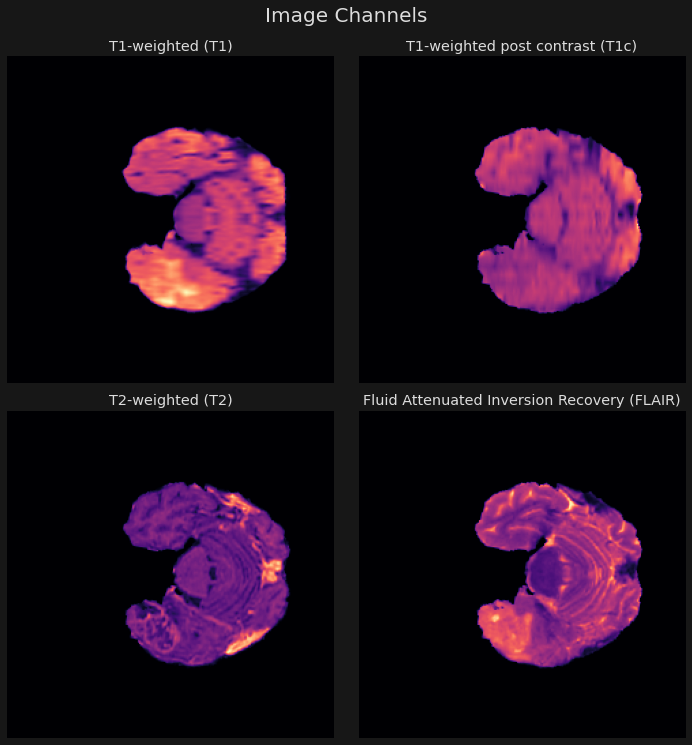

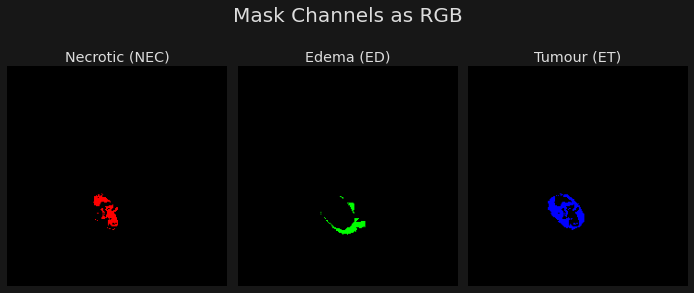

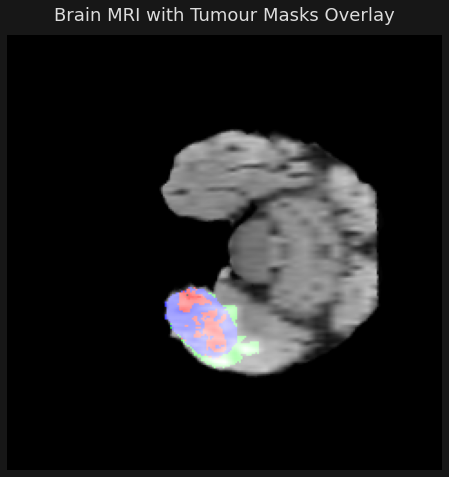

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for channel_idx, ax in enumerate(axes.flatten()):
        channel_image = image[channel_idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[channel_idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for channel_idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., channel_idx] = mask[channel_idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[channel_idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
def display_file(file_path):
    data = {}
    with h5py.File(file_path, 'r') as file:
        for key in file.keys():
            data[key] = file[key][()]

    # Transpose the image and mask to have channels first
    image = data['image'].transpose(2, 0, 1)
    mask = data['mask'].transpose(2, 0, 1)

    # View images using plotting functions
    display_image_channels(image)
    display_mask_channels_as_rgb(mask)
    overlay_masks_on_image(image, mask)
    
    
    
# Sample image to view
display_file(os.path.join(DATA_DIR, H5_FILES[25070]))

### Создаем Dataset и DataLoader
Наш датасет относительно большой - ~8GB, поэтому возпользуемся dataloader для загрузки пар данных батчами. Посколько данные формат данных нестандартный, нам нужно написать свой собственный Dataset object и DataLoader. 

Изображения сохранены в формате `float64` с интенсивностью пикселя от ~-0.5 до ~230 и `height`, `width`, `channels` последовательностью каналов. Маски сохраннены в `uint8` и пиксели там представлены 0 и 1. 

Наш Dataset должен загрузить изображение, зарешейпить его в  `channels`, `height`, `width`, поправить значения пикселей чтобы минимум был в 0 на каждом изображении, затем каждый канал, чтобы максимум был 1, затем сконвертировать в  `torch.float32` tensor.

---

### WARNING
The text of the task: 

```Наш Dataset должен загрузить изображение, зарешейпить его в  `channels`, `height`, `width`, поправить значения пикселей чтобы минимум был в 0 на каждом изображении, затем каждый канал, чтобы максимум был 1, затем сконвертировать в  `torch.float32` tensor.```


and the comment in the following code: 

```# Adjusting pixel values for each channel in the image so they are between 0 and 255```

contradict each other. 

#### <ins>Pixel values are left in range between 0 and 1</ins>

---

### 2 points

In [13]:
# Build .h5 file paths from directory containing .h5 files
H5_FILES = [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith('.h5')]

In [14]:
import tqdm

if False:
   # Find global min and max by channel for future normalization
   channels_min_max = {0: [1000, -1000], 1: [1000, -1000],
                       2: [1000, -1000], 3: [1000, -1000]}
   for f in tqdm.tqdm(H5_FILES, desc='files'):
      with h5py.File(f, 'r') as file:
         img = file['image']
         for i in range(4):
            ch = img[..., i]
            channels_min_max[i][0] = min(channels_min_max[i][0], ch.min())
            channels_min_max[i][1] = max(channels_min_max[i][1], ch.max())
else:
   channels_min_max = {0: [-0.7353662414128475, 239.99791665762442],
                       1: [-0.7397413925267599, 239.9979166576245],
                       2: [-0.7335039974147619, 239.99791665762447],
                       3: [-0.732924887806623, 239.99791665762442]}
channels_min_max

{0: [-0.7353662414128475, 239.99791665762442],
 1: [-0.7397413925267599, 239.9979166576245],
 2: [-0.7335039974147619, 239.99791665762447],
 3: [-0.732924887806623, 239.99791665762442]}

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image = np.transpose(image, (2, 0, 1))
            mask = np.transpose(mask, (2, 0, 1))

            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255 
            # ???
            for i in range(image.shape[0]):    # Iterate over channels
                t_image = image[i, :, :]
                image[i, :, :] = (t_image - channels_min_max[i][0]) / (channels_min_max[i][1] - channels_min_max[i][0])


            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask
            

np.random.seed(42)
np.random.shuffle(H5_FILES)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(H5_FILES))
train_files = H5_FILES[:split_idx]
val_files = H5_FILES[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    log.info('Training batch - Images shape:', images.shape, 'Masks shape:', masks.shape)
    assert images.shape == torch.Size([5, 4, 240, 240])
    assert masks.shape == torch.Size([5, 3, 240, 240])
    break
for images, masks in val_dataloader:
    log.info('Validation batch - Images shape:', images.shape, 'Masks shape:', masks.shape)
    break

[INFO]: Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
[INFO]: Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


## The UNet Architecture

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" 
     align="right" 
     width="500"
     style="padding: 20px;" />
     
[UNet](https://arxiv.org/abs/1505.04597) is a deep learning neural network architecture originally designed for image segmentation tasks, but has since found use in GANs and latent diffusion models. Similar to autoencoders, the UNet structures include an encoder for compressing the input into a lower dimensional representation and a decoder for reconstructing the output from this compressed form. However, UNet distinguishes itself from autoencoders with several features:


Подсказка: skip_connection может быть реазлизована как с помощью torch.cat, так и torch.add

### 4 points

Мы с вами писали UNet на семинаре, здесь нужно сделать то же самое - можно как перенсти архитектуру оттуда, либо дополнить скелетный код, который дан ниже. Можно и полностью переписать весь код здесь, сохранив лишь его верхнеуровневую структуру - класс для энкодера и декодера блоков, класс для модели.

Глубину можно менять по своему вкусу, но рекомендую не менее 3х слоев в глубину.

In [15]:
from torch import nn


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, padding=1,  bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, padding=1,  bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            activation
        )

    def forward(self, x):
        return self.encoder_block(x)


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=3, padding=1,  bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels,
                      kernel_size=3, padding=1,  bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            activation
        )

    def forward(self, x):
        return self.decoder_block(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Config
        in_channels = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters = 32  # Scaled down from 64 in original paper
        activation = nn.ReLU()

        # Up and downsampling methods
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, n_filters, activation)
        self.enc_block_2 = EncoderBlock(n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8*n_filters, 16*n_filters,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=16*n_filters),
            activation,
            nn.Conv2d(16*n_filters, 16*n_filters,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=16*n_filters),
            activation
        )

        # Decoder
        self.dec_block_4 = DecoderBlock(
            16*n_filters+8*n_filters, 8*n_filters, activation)
        self.dec_block_3 = DecoderBlock(
            8*n_filters+4*n_filters, 4*n_filters, activation)
        self.dec_block_2 = DecoderBlock(
            4*n_filters+2*n_filters, 2*n_filters, activation)
        self.dec_block_1 = DecoderBlock(
            2*n_filters+n_filters, n_filters, activation)

        # Output projection
        self.output = nn.Conv2d(
            1*n_filters,  out_channels, kernel_size=(1, 1), stride=1, padding=0)

    def forward(self, x):
        # Encoder
        enc1 = self.enc_block_1(x)
        enc2 = self.enc_block_2(self.downsample(enc1))
        enc3 = self.enc_block_3(self.downsample(enc2))
        enc4 = self.enc_block_4(self.downsample(enc3))

        # Bottleneck
        x = self.bottleneck(self.downsample(enc4))

        # Decoder
        x = self.upsample(x)
        x = self.dec_block_4(torch.cat((x, enc4), dim=1))
        x = self.upsample(x)
        x = self.dec_block_3(torch.cat((x, enc3), dim=1))
        x = self.upsample(x)
        x = self.dec_block_2(torch.cat((x, enc2), dim=1))
        x = self.upsample(x)
        x = self.dec_block_1(torch.cat((x, enc1), dim=1))

        return self.output(x)

# Function to count number of parameters in a model for comparisons later


def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    log.info(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path


def save_model(model, path='model_weights.pth'):
    torch.save(model.state_dict(), path)


count_parameters(UNet())

[INFO]: Total Parameters: 7,849,955



### Training Loop


### 4 points

In [27]:
def train_model(model, train_dataloader, val_dataloader, n_epochs = 10):
    device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
    learning_rate =  0.001
    batches_per_epoch = len(train_dataloader) 
    lr_decay_factor =  0.9
    if device == 'cpu':
        log.warning(f'device: {device}')

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    log.info('Training started')
    for epoch in range(1, n_epochs + 1):
        
        # Decay learning rate. Make it smaller with each epoch
        current_lr = learning_rate * (lr_decay_factor ** epoch)
        
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in tqdm.tqdm(enumerate(train_dataloader, start=1), total=batches_per_epoch):
            if train_batch_idx > batches_per_epoch:   # if you want lesser batches amount per epoch 
                log.warning(f'batch per epoch limit exceeded: {batches_per_epoch}')
                break
            log.debug(f'Train batch: {train_batch_idx}/{batches_per_epoch}, '
                      f'Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)

            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

        train_epoch_losses.append(train_epoch_loss)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for (val_inputs, val_targets) in val_dataloader:
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()

        val_epoch_losses.append(val_epoch_loss)

        log.info(f'Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, '
                 f'Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}')
        
    log.info("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [17]:
# Create UNet model and count params
model = UNet()
count_parameters(model)

[INFO]: Total Parameters: 7,849,955



In [34]:
# Train model
log.set_level(1) # info+ level
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader)
save_model(model, HOME_DIR+'/model_weights.pth')

[INFO]: Training started
100%|█████████▉| 10294/10295 [19:49<00:00,  8.66it/s]

[INFO]: Epoch: 1, Train loss: 121.497087, Val loss: 6.340085, lr 0.000900
100%|█████████▉| 10294/10295 [15:22<00:00, 11.16it/s]

[INFO]: Epoch: 2, Train loss: 45.769998, Val loss: 4.897360, lr 0.000810
100%|█████████▉| 10294/10295 [15:03<00:00, 11.39it/s]
[INFO]: Epoch: 3, Train loss: 38.864371, Val loss: 3.891958, lr 0.000729
100%|█████████▉| 10294/10295 [15:28<00:00, 11.09it/s]
[INFO]: Epoch: 4, Train loss: 34.871920, Val loss: 3.717354, lr 0.000656
100%|█████████▉| 10294/10295 [15:08<00:00, 11.33it/s]
[INFO]: Epoch: 5, Train loss: 31.689816, Val loss: 3.911107, lr 0.000590
100%|█████████▉| 10294/10295 [15:23<00:00, 11.14it/s]
[INFO]: Epoch: 6, Train loss: 29.317264, Val loss: 3.306073, lr 0.000531
100%|█████████▉| 10294/10295 [15:21<00:00, 11.18it/s]

[INFO]: Epoch: 10, Train loss: 22.228085, Val loss: 2.575198, lr 0.000349
[INFO]: Training complete.


```
Connection was lost during the learning process so some logs are missed :(
The learning process was quite slow. There is much faster approach (~x5 faster)
```

### Смотрим на результат
Здесь ничего менять не надо

In [20]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'
    
    _, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    # axis.set_ylim(0, 1)
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    

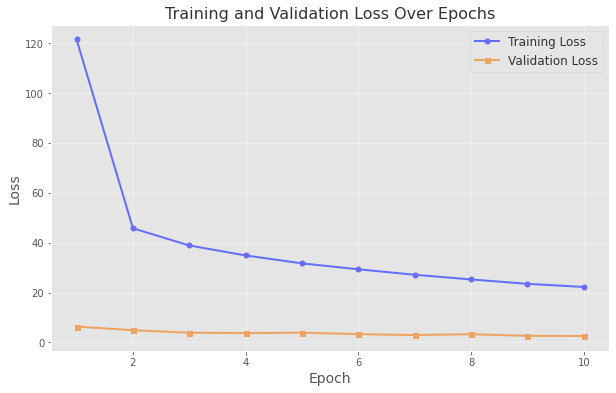

In [20]:
plot_learning_curves(train_epoch_losses, val_epoch_losses)

In [21]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    


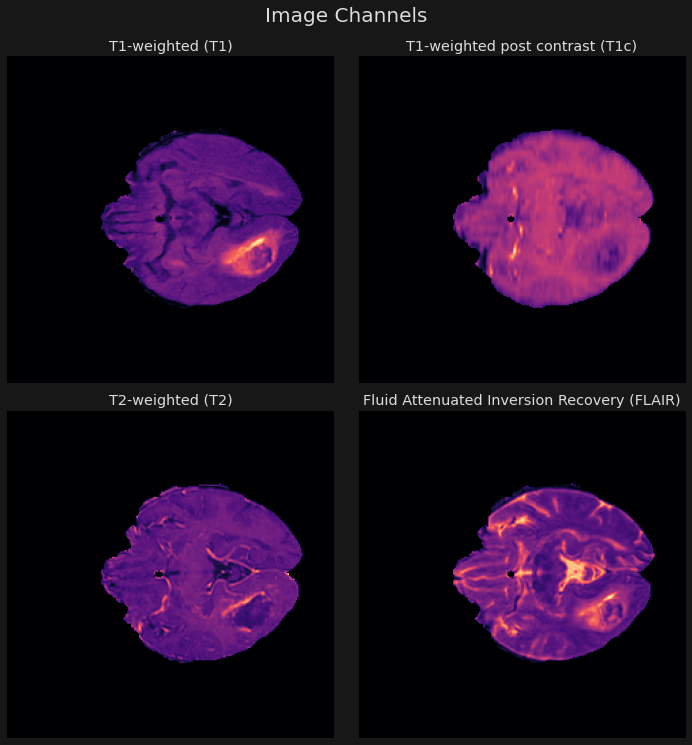

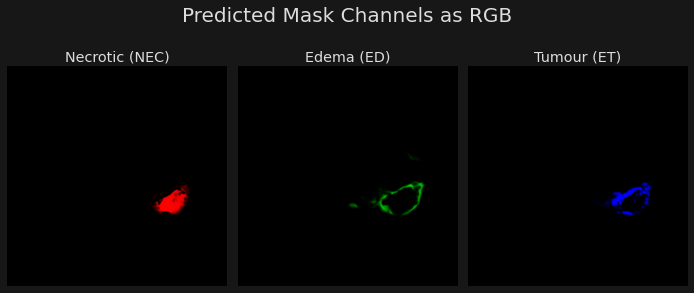

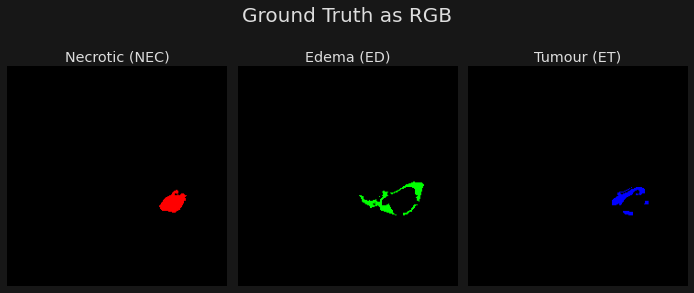

In [26]:
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

---

```

In conclusion, we can say that we taught our UNet successfully enough according to the results.

A larger number of epochs would improve our prediction quality, but the original way of accessing the data by loading it every time from the file system really slows the learning speed down. The speed is limited by the disk reading speed.

```

---

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader


class BrainScanDatasetInMem(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)

        self.data = []
        for file_path in tqdm.tqdm(self.file_paths):
            with h5py.File(file_path, 'r') as file:
                image = file['image'][()]
                mask = file['mask'][()]

                # Reshape: (H, W, C) -> (C, H, W)
                image = np.transpose(image, (2, 0, 1))
                mask = np.transpose(mask, (2, 0, 1))

                # Adjusting pixel values for each channel in the image so they are between 0 and 255
                # ???
                for i in range(image.shape[0]):    # Iterate over channels
                    t_image = image[i, :, :]
                    image[i, :, :] = (t_image - channels_min_max[i][0]) / \
                        (channels_min_max[i][1] - channels_min_max[i][0])

                image = torch.tensor(image, dtype=torch.float32)
                mask = torch.tensor(mask, dtype=torch.float32)
            self.data.append((image, mask))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [26]:
np.random.seed(42)
np.random.shuffle(H5_FILES)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(H5_FILES))
train_files_2 = H5_FILES[:split_idx]
val_files_2 = H5_FILES[split_idx:]

# Create the train and val datasets
train_dataset_2 = BrainScanDatasetInMem(train_files_2)
val_dataset_2 = BrainScanDatasetInMem(val_files_2, deterministic=True)

# Sample dataloaders
train_dataloader_2 = DataLoader(train_dataset_2, batch_size=5, shuffle=True)
val_dataloader_2 = DataLoader(val_dataset_2, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator_2 = iter(DataLoader(val_dataset_2, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader_2:
    log.info('Training batch - Images shape:', images.shape, 'Masks shape:', masks.shape)
    assert images.shape == torch.Size([5, 4, 240, 240])
    assert masks.shape == torch.Size([5, 3, 240, 240])
    break
for images, masks in val_dataloader_2:
    log.info('Validation batch - Images shape:', images.shape, 'Masks shape:', masks.shape)
    break

  0%|          | 0/51475 [00:00<?, ?it/s]

100%|██████████| 5720/5720 [01:18<00:00, 73.13it/s]

[INFO]: Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
[INFO]: Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


In [28]:
model_2 = UNet()
log.set_level(1) # info+ level
train_epoch_losses_2, val_epoch_losses_2 = train_model(model_2, train_dataloader_2, val_dataloader_2, n_epochs=15)

[INFO]: Training started


100%|██████████| 10295/10295 [03:19<00:00, 51.69it/s]


[INFO]: Epoch: 1, Train loss: 142.686107, Val loss: 7.183279, lr 0.000900


100%|██████████| 10295/10295 [03:17<00:00, 52.22it/s]


[INFO]: Epoch: 2, Train loss: 45.916838, Val loss: 4.574468, lr 0.000810


100%|██████████| 10295/10295 [03:17<00:00, 52.23it/s]


[INFO]: Epoch: 3, Train loss: 38.454416, Val loss: 4.206365, lr 0.000729


100%|██████████| 10295/10295 [03:16<00:00, 52.32it/s]


[INFO]: Epoch: 4, Train loss: 34.155798, Val loss: 3.596701, lr 0.000656


100%|██████████| 10295/10295 [03:16<00:00, 52.26it/s]


[INFO]: Epoch: 5, Train loss: 30.720696, Val loss: 4.119300, lr 0.000590


100%|██████████| 10295/10295 [03:16<00:00, 52.31it/s]


[INFO]: Epoch: 6, Train loss: 28.141776, Val loss: 3.251688, lr 0.000531


100%|██████████| 10295/10295 [03:16<00:00, 52.30it/s]


[INFO]: Epoch: 7, Train loss: 25.731950, Val loss: 2.995753, lr 0.000478


100%|██████████| 10295/10295 [03:16<00:00, 52.32it/s]


[INFO]: Epoch: 8, Train loss: 23.899381, Val loss: 2.733000, lr 0.000430


100%|██████████| 10295/10295 [03:16<00:00, 52.30it/s]


[INFO]: Epoch: 9, Train loss: 22.323293, Val loss: 2.527270, lr 0.000387


100%|██████████| 10295/10295 [03:16<00:00, 52.31it/s]


[INFO]: Epoch: 10, Train loss: 20.937278, Val loss: 2.384182, lr 0.000349


100%|██████████| 10295/10295 [03:16<00:00, 52.27it/s]


[INFO]: Epoch: 11, Train loss: 19.720556, Val loss: 2.306321, lr 0.000314


100%|██████████| 10295/10295 [03:16<00:00, 52.38it/s]


[INFO]: Epoch: 12, Train loss: 18.730230, Val loss: 2.196283, lr 0.000282


100%|██████████| 10295/10295 [03:16<00:00, 52.30it/s]


[INFO]: Epoch: 13, Train loss: 17.857244, Val loss: 2.093102, lr 0.000254


100%|██████████| 10295/10295 [03:17<00:00, 52.22it/s]


[INFO]: Epoch: 14, Train loss: 17.167859, Val loss: 2.067988, lr 0.000229


100%|██████████| 10295/10295 [03:16<00:00, 52.35it/s]


[INFO]: Epoch: 15, Train loss: 16.517827, Val loss: 1.973948, lr 0.000206
[INFO]: Training complete.


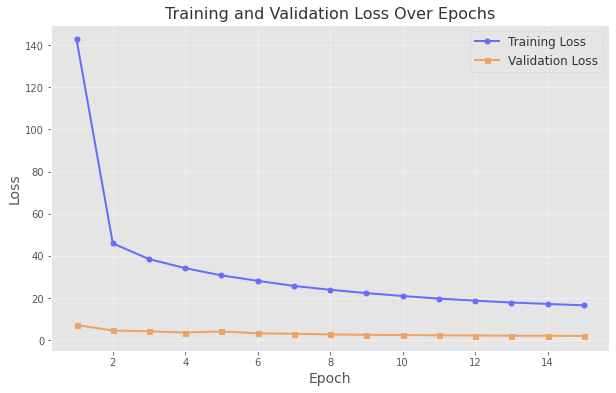

In [29]:
plot_learning_curves(train_epoch_losses_2, val_epoch_losses_2)

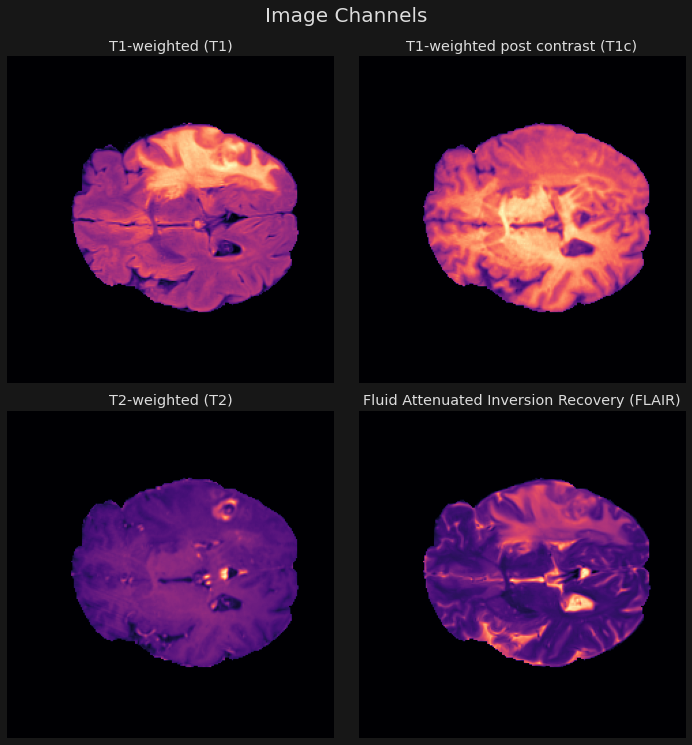

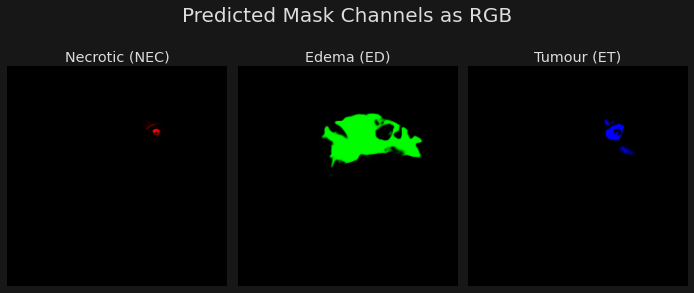

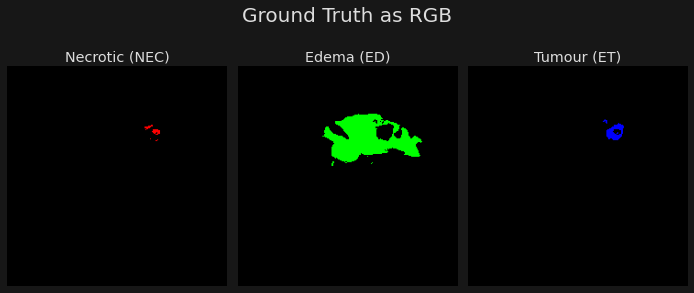

In [30]:
test_input, test_target = next(test_input_iterator_2)

display_test_sample(model_2, test_input, test_target, device)

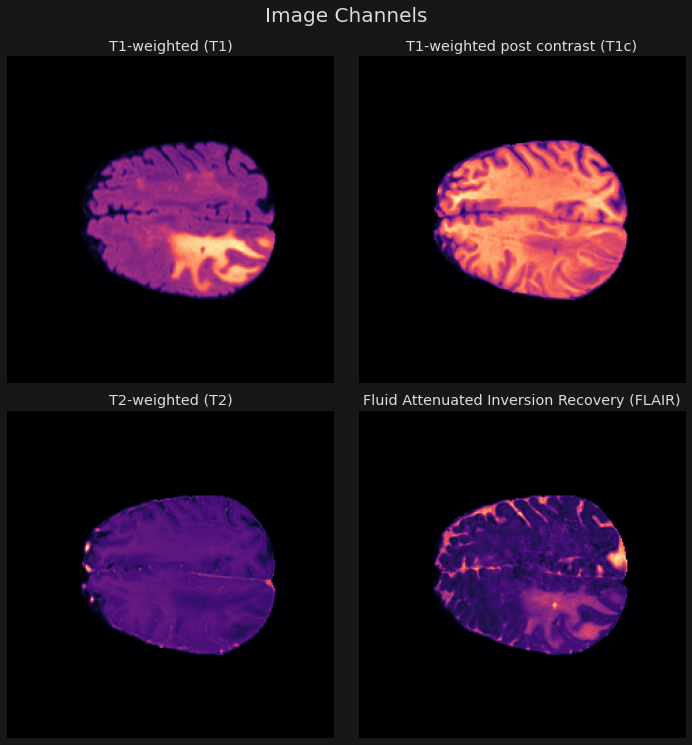

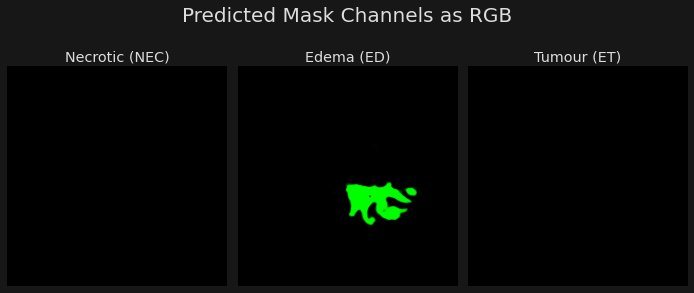

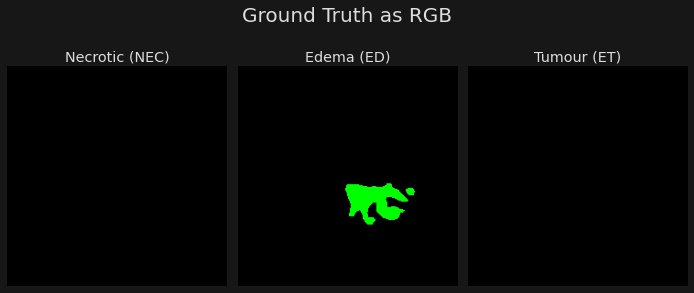

In [32]:
test_input_iterator_3 = iter(DataLoader(train_dataset_2, batch_size=1, shuffle=True))
test_input, test_target = next(test_input_iterator_3)
display_test_sample(model_2, test_input, test_target, device)

```
The second model has better accuracy. And it can be tought much faster. But the host have to have a lot of RAM (empirically ~80Gb)
```
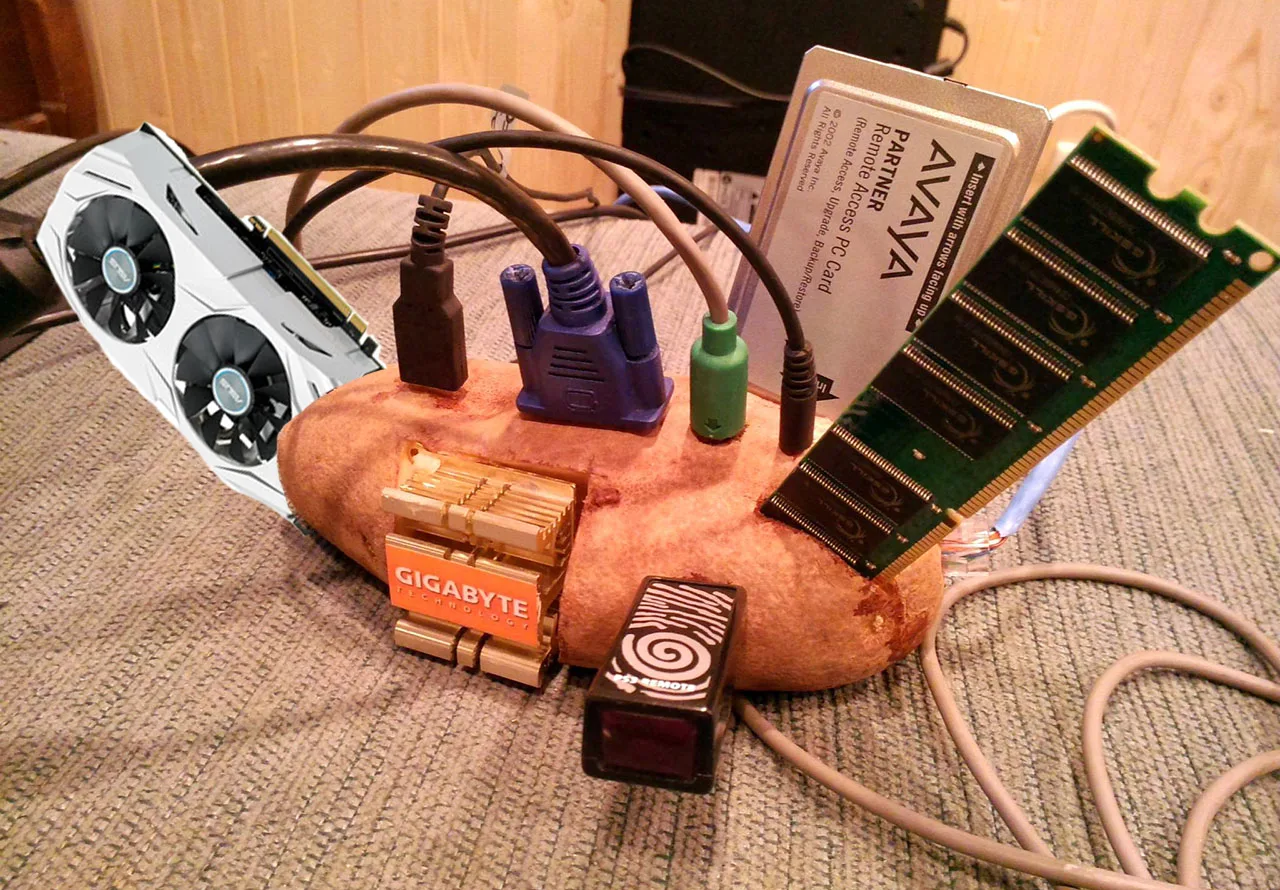